In [71]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO #스토캐스틱 VI ,ELBO 통해서 변분추론 실시예정
from pyro.optim import Adam 

pyro.set_rng_seed(0)


예제 : Clustering

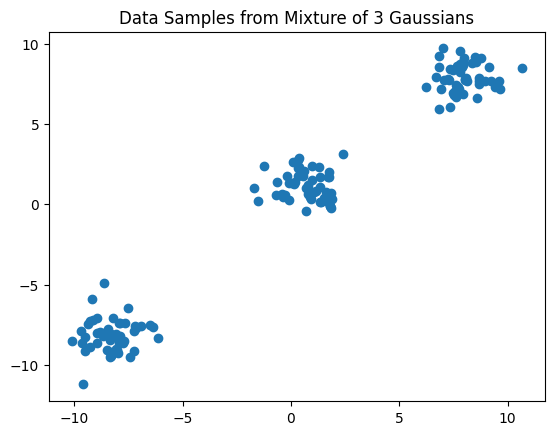

In [84]:
MEAN = torch.ones(2)
COV = torch.eye(2)
MEAN2 = torch.tensor([0.5,1])
data = torch.cat([
    MultivariateNormal(-8 * MEAN, COV).sample([50]),
    MultivariateNormal(8 * MEAN, COV).sample([50]),
    MultivariateNormal(MEAN2, COV).sample([50])
])
plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 3 Gaussians")
plt.show()



디리클렛 과정을 통한 혼합모형으로 이 세 군집을 분석해볼 것

In [73]:
#Stick-breaking weights
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta,(0,1), value =1) * F.pad(beta1m_cumprod, (1,0), value = 1) #누적으로 곱해나가는 형태


#DPMM weight를 구성하는 것은 beta분포 / 기본분포는 정규분포의 혼합
#디리클렛 혼합모형형
def model(data):
    global T
    with pyro.plate("beta_plate", T - 1):
        beta = pyro.sample("beta", Beta(1, alpha)) #beta는 stick-breaking을 위한 beta분포로 구성됨, alpha는 하이퍼파라미터
    T = beta.shape[0] + 1 #테이블의 개수는 beta의 개수 + 1

    I2 = torch.eye(2)
    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * I2)) #G0는 정규분포 평균 0 분산 5

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) #테이블 번호를 표시하는 z
        #z는 beta를 통해서 stick-breaking으로 구성된 혼합모델의 테이블 번호를 나타냄
        pyro.sample("obs", MultivariateNormal(mu[z], I2), obs=data)

In [74]:
#변분추론을 하기 위해서는 변분분포를 결정해야 함, mean-field를 사용, 다 곱하기의 형태
#블레이에 의해 제안된 분포
def guide(data):
    global T
    kappa = pyro.param("kappa", lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive) #kappa는 하이퍼파라미터
    I2 = torch.eye(2)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3*I2).sample([T])) #tau는 평균과 분산을 나타내는 파라미터
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint = constraints.simplex) #phi는 각 데이터가 속하는 테이블의 확률을 나타내는 파라미터
    with pyro.plate("beta_plate", T - 1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa)) #beta는 stick-breaking을 위한 beta분포로 구성됨
    
    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2))) #mu는 정규분포로 구성됨

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi)) #z는 각 데이터가 속하는 테이블의 확률을 나타내는 파라미터

이렇게 가이드를 생성하고 모형을 이용해서 SVI 생성 , 이 SVI 에서 adam 옵티마이저 이용 업데이트 실시시

In [75]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
elbo_values = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        elbo = svi.step(data)
        elbo_values.append(elbo)
    print(f"ELBO: {elbo_values[-1] / N:.2f}")  # 평균 ELBO 출력
alpha = 1.0  # 하이퍼파라미터 alpha
train(2000)

100%|██████████| 2000/2000 [00:14<00:00, 140.44it/s]

ELBO: 8.94


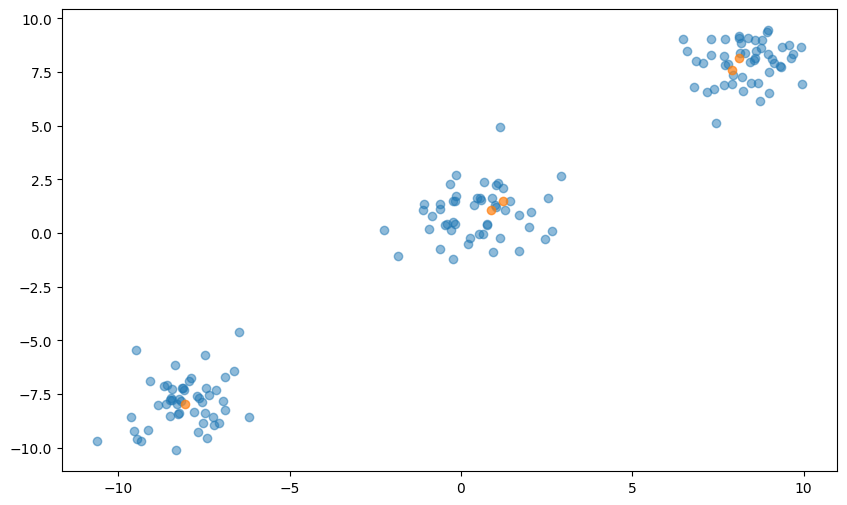

In [76]:
#값 추출해 활용하기 T :이론적으로는 무한대지만 실제로는 어느정도의 크기로 제한

def truncate(alpha, centers, weights):
    threshold = alpha**-1/10.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

#We make a point-estimate of our model parameters using
#the posterior means of tau and phi fir the centers and weights
Bayes_Centers, Bayes_Weights = truncate(alpha, pyro.param("tau").detach(), 
                                        torch.mean(pyro.param("phi").detach(), dim = 0))
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], label="Data", alpha=0.5)
plt.scatter(Bayes_Centers[:, 0], Bayes_Centers[:, 1], 
             label="Estimated Centers", alpha=0.7)

Density estimation 예제 :ㅣLong term solar observations

In [77]:
DATASET_URL = "http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv"
dset = pd.read_csv(DATASET_URL, sep=";",skiprows=1)
dset.head(30) 

,1701.5,18.3,-1.0,-1,1
0,1702.5,26.7,-1.0,-1,1
1,1703.5,38.3,-1.0,-1,1
2,1704.5,60.0,-1.0,-1,1
3,1705.5,96.7,-1.0,-1,1
4,1706.5,48.3,-1.0,-1,1
5,1707.5,33.3,-1.0,-1,1
6,1708.5,16.7,-1.0,-1,1
7,1709.5,13.3,-1.0,-1,1
8,1710.5,5.0,-1.0,-1,1
9,1711.5,0.0,-1.0,-1,1


In [78]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

#DPMM
def model(data):
    global T
    with pyro.plate("beta_plate", T - 1):
        beta = pyro.sample("beta", Beta(1, alpha))
    T = beta.shape[0] + 1

    with pyro.plate("lambda_plate", T):
        lmbda = pyro.sample("lambda", Gamma(3, 0.05))  # 포아송 분포의 람다 파라미터를 감마분포로 모델링

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", Poisson(lmbda[z]), obs=data)
        #카운트 자료 모델링을 위해 포아송 분포를 사용

In [79]:
#변분분포
def guide(data):
    kappa = pyro.param("kappa", lambda: Uniform(0, 2).sample([T - 1]), constraint=constraints.positive)
    tau_0 = pyro.param('tau_0', lambda: Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', lambda: LogNormal(-1,1).sample([T]), constraint=constraints.positive)
    phi = pyro.param('phi', lambda: Dirichlet(1 / T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T - 1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T - 1), kappa))

    with pyro.plate("lambda_plate", T):
        q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

In [82]:

T =20
alpha = 1.0  # 하이퍼파라미터 alpha
n_iter = 2000
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
elbo_values = []
train(n_iter)

  0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: Error while computing log_prob at site 'obs':
Value is not broadcastable with batch_shape+event_shape: torch.Size([150, 2]) vs torch.Size([150]).
Trace Shapes:          
 Param Sites:          
Sample Sites:          
    beta dist      19 |
        value      19 |
     log_prob      19 |
  lambda dist      20 |
        value      20 |
     log_prob      20 |
       z dist     150 |
        value     150 |
     log_prob     150 |
     obs dist     150 |
        value 150   2 |

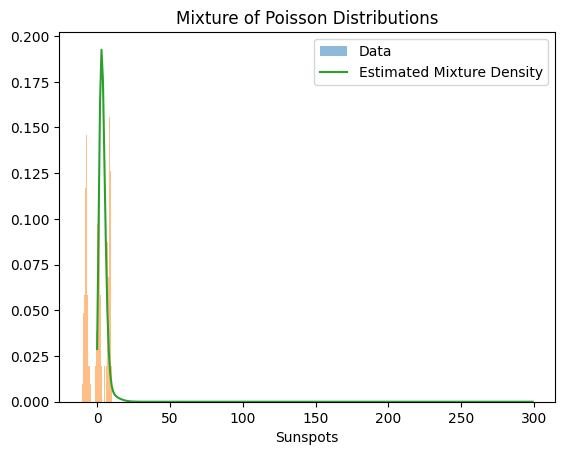

In [ ]:
#사후 추론을 위해 모수들의 값을 뽑아 사용하기
samples = torch.arange(0,300).type(torch.float)

tau0_optimal = pyro.param("tau_0").detach()
tau1_optimal = pyro.param("tau_1").detach()
kappa_optimal = pyro.param("kappa").detach()

#We make point-estimate of our latent variables using
#the posterior means of tau and kappa for the cluster params and weights

Bayes_Rates = (tau0_optimal / tau1_optimal)
Bayes_Weights = mix_weights(1./ (1. + kappa_optimal))

def mixture_of_poisson(weights, rates, samples):
    # weights: (T,)       → (1, T)
    # rates:   (T,)       → (1, T)
    # samples: (300,)     → (300, 1)

    weights = weights.view(1, -1)     # (1, T)
    rates   = rates.view(1, -1)       # (1, T)
    x       = samples.unsqueeze(-1)   # (300, 1)

    # Poisson(rates) batch_shape=(T,) → (1, T) 로 변경
    # log_prob(x)  → broadcast (300,1) vs. (1, T) → 결과 (300, T)
    log_p = Poisson(rates).log_prob(x)   # shape = (300, T)

    # exp(log_p) = Poisson(rates).prob(x) → (300, T)
    prob_x_given_k = log_p.exp()        # shape = (300, T)

    # 가중치 곱 → (1,T) × (300,T) → broadcast → (300, T)
    weighted_prob = weights * prob_x_given_k

    # 마지막으로 k 차원(=dim=1)을 따라 합 → (300,)
    mixture_density = weighted_prob.sum(dim=1)  # shape = (300,)

    return mixture_density
liklihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Mixture of Poisson Distributions")
plt.xlabel("Sunspots")
plt.hist(data.numpy(), bins=30, density=True,lw=0, alpha=0.5, label="Data")
plt.plot(samples,liklihood,label = "Estimated Mixture Density")
plt.legend()
plt.show()